In [ ]:
from IPython.display import display, Math
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import scipy.linalg as la
import chapter_6_utils

In [3]:
def load_data() -> pd.DataFrame:
    fpth = pathlib.Path(r'..\..\data\Table6.8.xlsx')
    df = pd.read_excel(fpth)
    return df

In [257]:
df = load_data()

- $X_{1} = \text{median reaction time for word format-different parity combination}$
- $X_{2} = \text{median reaction time for word format-same parity combination}$
- $X_{3} = \text{median reaction time for Arabic format-different parity combination}$
- $X_{4} = \text{median reaction time for Arabic format-same parity combination}$

## (a)

Test for treatment effects using a *repeated measures design*. Set $\alpha = .05$.

Use the formula from page 280,
$$
H_{0}: \textbf{C} \bm{\mu} = \textbf{0}
\hspace{0.20cm}\text{versus}\hspace{0.20cm}
H_{0}: \textbf{C} \bm{\mu} \ne \textbf{0}
$$

In [23]:
alpha = 0.05
n, q = df.shape

In [24]:
q

4

In [25]:
C = ((-1)*np.diag([1]*(q-1), k=-1) + np.diag([1]*q))[1:,:]

In [9]:
display(Math(fr"\textbf{{C}} = {chapter_6_utils.create_array_text(C)}"))

<IPython.core.display.Math object>

In [27]:
xbar = np.mean(df, axis=0).to_numpy()[:, np.newaxis]
S = np.cov(df, rowvar=False)

In [28]:
T2 = (n * (C @ xbar).T @ la.inv(C @ S @ C.T) @ (C @ xbar)).item()

In [29]:
display(Math('T^{2}'
             '='
             r'n{(\textbf{C}\bar{\textbf{x}})}^{\prime}'
             r'{\left(\textbf{C}\textbf{S}{\textbf{C}}^{\prime}\right)}^{-1}'
             r'\textbf{C}\bar{\textbf{x}}'
             '='
             f'{T2:.4f}'
             ))

<IPython.core.display.Math object>

In [37]:
F_crit = stats.f.ppf(1-alpha/2, dfn=q-1, dfd=n-q+1)
const = ((n-1)*(q-1))/(n-q+1)*F_crit

In [42]:
if T2 > const*F_crit:
    display(Math(fr'\text{{We have that }} T^{{2}} = {T2:.3f} > '
                 r'F_{\text{crit}}'
                 '='
                 fr'F_{{ q-1, n-q+1 }} \left( \alpha \right)'
                 '='
                 fr'F_{{ {q-1}, {n-q+1} }} \left( {alpha} \right) = {const*F_crit:.3f}'
                 r'\text{{, so we would reject the null hypothesis that }} '
                 r'\textbf{C}\bm{\mu} = \textbf{0}'
                 ))
else:
    display(Math(fr'\text{{We have that }} T^{{2\star}} = {T2:.3f} \leq '
                 r'F_{\text{crit}}'
                 '='
                 fr'F_{{ q-1, n-q+1 }} \left( \alpha \right)'
                 '='
                 fr'F_{{ {q-1}, {n-q+1} }} \left( {alpha} \right) = {const*F_crit:.3f}'
                 r'\text{{, so we would fail to reject the null hypothesis that }} '
                 r'\textbf{C}\bm{\mu} = \textbf{0}'
                 ))

<IPython.core.display.Math object>

## (b)

Construct 95% (simultaneous) confidence intervals for the contrasts representing
the number format effect, the parity type effect and the interaction effect. Interpret
the resulting intervals.

Using the formula on page 281,
$$
    {\textbf{c}}^{\prime} \bm{\mu}
    \text{:}\hspace{0.20cm}
    {\textbf{c}}^{\prime} \bar{\textbf{x}}
    \pm
    \sqrt{
        \frac{(n-1)(q-1)}{(n-q+1)}
        F_{q-1, n-q+1}\left( \alpha \right)
        }
    \sqrt{\frac{{\textbf{c}}^{\prime} \textbf{S} \textbf{c}}{n}}
$$

In [49]:
c1 = np.array([-1, -1, 1, 1])[:, np.newaxis]  # Number format effect contrast.
c2 = np.array([1, -1, 1, -1])[:, np.newaxis]  # Parity type effect constast.
c3 = np.array([1, -1, -1, 1])[:, np.newaxis]  # Interaction effect contrast.

In [236]:
def repeated_measure_ci(X: pd.DataFrame, c: np.ndarray, alpha: float) -> np.ndarray:
    """
    Construct simultaneous confidence intervals for contrasts from a repeated measure design. 
    Args:
        X (pd.DataFrame): The data of interest in the form of rows of observations and columns of variables.
        c (np.ndarray): A contrast related to the input dataframe.
        alpha: The alpha-level to use when constructing the CI.
    Returns:
        np.ndarray: The lower/upper simultaneous confidence interval values for the repeated measure data.
    """
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    n, q = X.shape
    xbar = X.mean(axis=0)[:, np.newaxis]
    S = np.cov(X, rowvar=False)

    const = ((n-1)*(q-1))/(n-q+1)
    F_crit = stats.f.ppf(1-alpha/2, dfn=q-1, dfd=n-q+1)

    ci = c.T @ xbar + np.array([-1, 1]) * np.sqrt(const * F_crit) * np.sqrt((c.T @ S @ c) / n)

    neg = np.where(c < 0)[0]+1
    pos = np.where(c > 0)[0]+1
    display(Math(r'\begin{array}{ll}'
                 fr'(\bar{{ x_{pos[0]} }} + \bar{{ x_{pos[1]} }}) - (\bar{{ x_{neg[0]} }} + \bar{{ x_{neg[1]} }})'
                 r'\pm'
                 fr'\sqrt{{ \frac{{ {n-1}({q-1}) }}{{ {n-q+1} }} F_{{ {q-1}, {n-q+1} }} ({alpha}) }}'
                 fr'\sqrt{{ \frac{{ {{\textbf{{c}} }}^{{\prime}} \textbf{{S}} \textbf{{c}} }}{{ {n} }} }}'
                 '& ='
                 f'{(c.T @ xbar).item():.2f}'
                 r'\pm'
                 fr'\sqrt{{ {const * F_crit:.2f} }}'
                 fr'\sqrt{{ \frac{{ {(c.T @ S @ c).item():.2f} }}{{ {n} }} }}'
                 r'\\'
                 '& ='
                 f'{(c.T @ xbar).item():.2f}'
                 r'\pm'
                 f'{np.sqrt(const * F_crit) * np.sqrt((c.T @ S @ c).item()/n):.2f}'
                 r'\\'
                 '& ='
                 f'[{ci[0,0]:.2f}, {ci[0,1]:.2f}]'
                 r'\end{array}'
                 ))
    return ci


In [238]:
display(Math(r"\text{ The 95\% confidence interval for the number format effect contrast is: }"))
ci1 = repeated_measure_ci(df, c1, alpha)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

With 95% confidence, the mean arabic digits score is between 186 and 428 points lower than that of word scores.

In [239]:
display(Math(r"\text{ The 95\% confidence interval for the type effect contrast is: }"))
ci2 = repeated_measure_ci(df, c2, alpha)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

With 95% confidence, the mean "different" numeric parity score is between 122 and 290 points higher than that of "same" numerical parity scores.

In [240]:
display(Math(r"\text{ The 95\% confidence interval for the interaction effect contrast is: }"))
ci3 = repeated_measure_ci(df, c3, alpha)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

With 95% confidence, the mean score for interaction between number format effect and type effect is between -82 and 37.
We have zero in the interval, so we could conclude that there is no interaction effect.

## (c.)

 The absence of interaction supports the $M$ model of numerical cognition, while the
presence of interaction supports the $C$ and $C$ model of numerical cognition. Which
model is supported in this experiment?

In part (b), we found that the 95% simultaneous confidence interval for interaction contained zero, so we'd conclude that there is no interaction effect.
The absence of interaction supports the $M$ model of numerical cognition.

## (d.)

For each subject, construct three difference scores corresponding to the number format
contrast, the parity type contrast, and the interaction contrast. Is a multivariate
normal distribution a reasonable population model for these data? Explain.

Use the contrasts $\textbf{c}_{1}$, $\textbf{c}_{2}$, and $\textbf{c}_{3}$, costructed in part (b) for this.

In [ ]:
df["NumberFormatContrast"], df["ParityTypeContrast"], df["InteractionContrast"] = df @ c1, df @ c2, df @ c3

In [288]:
contrast_df = df[["NumberFormatContrast", "ParityTypeContrast", "InteractionContrast"]].copy()

In [ ]:
def chi2_plot(df: pd.DataFrame) -> None:
    """
    Create a Chi-squared plot to check for multivariate normality.
    Args:
        df (pd.DataFrame): Dataframe with variables to use for the plot in the format $n \times p$.
    Returns:
        None
    """
    X = df.copy().to_numpy()
    n, p = X.shape
    xbar = X.mean(axis=0)[:, np.newaxis]
    S = np.cov(X, rowvar=False)

    d2 = np.diag((X.T - xbar).T @ la.inv(S) @ (X.T - xbar))[:, np.newaxis]
    d2_sorted = np.sort(d2, axis=0)
    q = stats.chi2.ppf((np.arange(1, n+1) - 0.5) / n, df=p)

    plt.scatter(q, d2_sorted, facecolors='none', edgecolors='royalblue')
    plt.plot([q.min(), q.max()], [q.min(), q.max()], color='black', lw=0.5)
    plt.xlabel(r"$\chi_{p}^{2}$ theoretical values")
    plt.ylabel("Ordered $d^{2}$")
    plt.title(r"$\chi_{p}^{2}$ plot")
    plt.show()

    # return d2_sorted
    

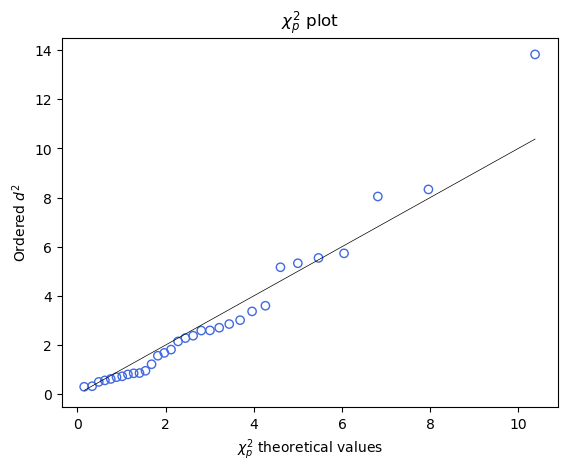

In [364]:
chi2_plot(contrast_df)

In [407]:
def mardia_test(df: pd.DataFrame):
    """
    Use the Mardia test for multivariate normality.
    Basically used what's here: https://real-statistics.com/multivariate-statistics/multivariate-normal-distribution/multivariate-normality-testing/
    """
    X = df.to_numpy()
    n, p  = X.shape
    xbar  = X.mean(axis=0)
    S     = np.cov(X, rowvar=False)
    d2    = ((X - xbar) @ la.inv(S) * (X - xbar)).sum(axis=1)[:, np.newaxis]

    # Mardia skewness (b1,p) and kurtosis (b2,p)
    b1p = np.sum((d2.T @ d2)**3) / n**2
    b2p = np.mean(d2**2)

    # Large-sample reference distributions:
    z_skew = n*b1p/6
    kappa  = (b2p - p*(p+2)) / np.sqrt(8*p*(p + 2)/n)
    
    p_skew = 1 - stats.chi2.cdf(z_skew, df=p*(p + 1)*(p + 2)/6)
    p_kurt = 2*(1 - stats.norm.cdf(abs(kappa)))

    return {"skew p-value": p_skew, "kurtosis p-value": p_kurt}

In [406]:
mardia_test(contrast_df)

{'skew p-value': 0.0, 'kurtosis p-value': 0.36038012638900585}

The $\chi^{2}$-plot shows some deviation from the line, which isn't promising.
I also created code for the Mardia Multivariate normal test.
The Mardia test is very significant for skewness and not significant for kurtosis.
Since both tests are not significant, we'd conclude that the data for the contrasts is not multivariate normal.